IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*

# TD-TME05: les arbres de décision

L'objectif de ce TP est d'implémenter un algorithme d'apprentissage supervisé, l'algorithme de construction d'arbres de décision vu en cours.

Dans un premier temps, nous allons nous restreindre à un cas binaire où les classes sont étiquetées $+1$ ou $-1$. De plus, nous allons ne considérer que le cas où les attributs sont tous numériques et on ne construit que des arbres avec des noeuds binaires (ie. qui ne contiennent que 2 branches sortantes).

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

CARNIELLI Ariana

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-05</tt> et rajouter à la suite de <tt>tme-05</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-05-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le notebook tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">** à la fin de la séance**</font>. C'est ce compte-rendu qui donne la note de base de la séance.
- vous pouvez éventuellement compléter votre compte-rendu  pour obtenir des points bonus, dans ce cas, vous devez soumettre votre complément avant le début de la semaine suivante.

** Sur la page Moodle de remise du travail <font color="RED">ne pas oublier d'envoyer le compte rendu</font>** à la fin de la séance, la soumission de la version complémentaire post-séance se fera sur une page différente.

## Mise à jour de votre librairie IADS

Comme lors des séances précédentes, vous devez utiliser les fonctions de la librairie IADS.

<font color="RED" size="+1">**[Q]**</font> **Ouvrir et compléter les fichiers Classifiers.py et utils.py**

Rajouter dans la librairie les fonctions et classes et que vous avez écrites lors de la séance précédente. 

**Rappel**: dans un premier temps, vous devez écrire les classes et fonctions demandées dans le notebook de la séance de TDTME en cours. Lors de la séance suivante, vous rajouterez tout cela, une fois que vous l'aurez bien testé, dans vos fichiers de la librairie IADS.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

### Génération de données Jouet

<font color="RED" size="+1">**[Q]**</font>  Dans un premier temps, pour mettre au point les fonctions, générer une base jouet assez petite (par exemple, 10 exemples de chaque classe).

In [2]:
the_set = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),10)

print("Taille de la base jouet générée : " + str(the_set.size()) + " exemples")

Taille de la base jouet générée : 20 exemples


In [3]:
S= the_set.x[np.where(the_set.y == 1),:]
print(type(S))
print(S.shape)
S[0]

<class 'numpy.ndarray'>
(2, 10, 2)


array([[ 1.70986665,  2.70314631],
       [ 1.64831594,  0.65554611],
       [ 0.48201136,  0.44970037],
       [ 1.84873284,  2.05666343],
       [ 0.96890174,  0.3508808 ],
       [ 1.57430987, -1.63656536],
       [ 0.45291649, -0.00985634],
       [ 1.77677785, -0.16200372],
       [ 1.43994441,  2.27303767],
       [ 0.5231828 , -0.17903602]])

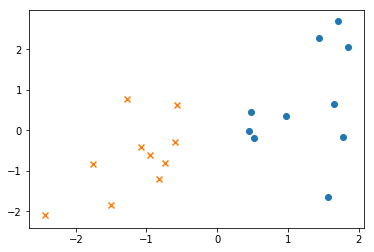

In [4]:
# Affichage du dataset généré
ut.plot2DSet(the_set)

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire()</code> qui, étant donné un LabeledSet rend la classe majoritaire dans l'ensemble (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la classe +1.

In [5]:
def classe_majoritaire(LabeledSet):
    nb_plus = (LabeledSet.y==1).sum()
    nb_moins = (LabeledSet.y==-1).sum()
    if nb_plus >= nb_moins:
        return 1
    return -1
    

In [6]:
classe_majoritaire(the_set)

1

## Arbres de décision

Dans cette étape, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Entropie et gain d'information

On note $\{c_1, c_2,..., c_k\}$, l'ensemble des classes possibles.

Dans le cours, la mesure de désordre présentée utilise, pour toute valeur $c$ de la classe le ratio $\frac{|Y(c)|}{|Y|}$ qui correspond à la probabilité de la classe $c$ parmi $Y$.
On note dans ce qui suit $p_1$ la probabilité de la classe $c_1$ parmi $Y$, etc. 

Ainsi, on a $P=(p_1, p_2,..., p_k)$ la distribution de probabilités sur les classes ainsi définies.

L'**entropie de Shannon** de la distribution $P$ est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur normalisée de l'entropie. 

*Remarque:* avec les notations vues en cours, on a $D(Y) = H_S(P)$.

Pour ce qui suit, une *distribution de probabilités* est représentée par une **liste** Python $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>shannon()</code> qui, étant donné une distribution de probabilités $P$, rend la valeur de $H_S(P)$, l'entropie de Shannon de $P$.

In [7]:
def shannon(P):
    if len(P) == 1:
        return 0
    entropie = 0
    taille = len(P)
    for pi in P:
        if pi != 0:
            #print(pi)
            entropie = entropie - (pi * math.log(pi, taille))
    return entropie

In [8]:
# Exemples d'utilisation:
print("P=[1,0] : ", shannon([1, 0]))
print("P=[0.25, 0.25, 0.25, 0.25] : ", shannon([0.25, 0.25, 0.25, 0.25]))
print("P=[0.7, 0.1, 0.2, 0.0] : ", shannon([0.7, 0.1, 0.2, 0.0]))
print("P=[1.0/3, 2.0/3] : ", shannon([1.0/3, 2.0/3]))

P=[1,0] :  0.0
P=[0.25, 0.25, 0.25, 0.25] :  1.0
P=[0.7, 0.1, 0.2, 0.0] :  0.5783898247235197
P=[1.0/3, 2.0/3] :  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> Tracer, à l'aide de la fonction plot, la courbe donnant la valeur de <code>shannon([p, 1-p])</code> en fonction de <code>p</code>.

In [9]:
import matplotlib.pyplot as plt

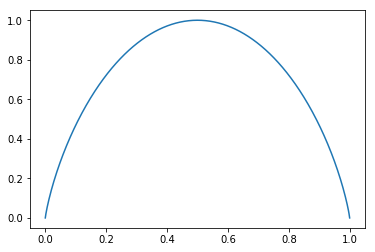

In [10]:
p = np.linspace(0, 1, 500)
shannon_p = []
for i in range(len(p)):
    shannon_p.append(shannon([p[i], 1-p[i]]))

plt.plot(p, shannon_p)

<font color="RED" size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon()</code>, écrire la fonction <code>entropie()</code> qui prend un LabeledSet en argument et renvoie l'entropie de la distribution des classes dans cet ensemble.

In [11]:
def entropie(LabeledSet):
    dico_type = {}
    taille_label = LabeledSet.size()
    for y in range(taille_label):
        type = LabeledSet.getY(y)
        if type[0] in dico_type:
            dico_type[type[0]] += 1
        else:
            dico_type[type[0]] = 1
    P = []
    for type in dico_type:
        P.append(dico_type[type]/taille_label)
    #print(P)
    return shannon(P)

In [12]:
entropie(the_set)

1.0

Cette fonction <code>entropie</code> permet dont de calculer le désordre des classes dans le LabeledSet considéré.

### Discrétisation des attributs numériques

Comme on l'a vu en cours, discrétiser un attribut numérique consiste en trouver un seuil de coupure dans son ensemble de valeurs. 

Par exemple, soit l'attribut Age contenant les valeurs 17, 18, 20, 27, 35, 37, 40. On discrétise cet attribut en 2 valeurs en prenant, par exemple, le seuil 30: cela permet de séparer d'un côté les valeurs inférieures ou égales à 30, et de l'autre les valeurs strictement supérieures à 30.

Le seuil est choisi afin d'optimiser la distribution des classes des exemples qui se trouvent de chaque côté du seuil. Une fois un seuil choisi, on calcule le désordre des classes associées aux exemples de chaque côté du seuil et on agrège les 2 valeurs de désordre obtenues pour déterminer la qualité de la coupure à l'aide de la mesure $Q$ vue en cours.


Soit $X$ un ensemble d'exemples, et soit $A$ un attribut que l'on souhaite discrétiser. Pour cela, on constitue l'ensemble des valeurs prises par les exemples de $X$ pour l'attribut $A$. Soit $A_X$ cet ensemble de valeurs.

La discrétisation de $A_X$ s'effectue par les étapes suivantes:
- Etape 1: ordonner de façon croissante les valeurs de $A_X$;
- Etape 2: regarder tous les seuils possibles de coupure entre 2 valeurs consécutives de $A_X$ (on prend comme seuil de coupure la valeur médiane entre ces 2 valeurs). Chaque seuil trouvé créé 2 intervalles qui générent 2 sous-ensembles de $X$: l'ensemble $X_1$ des exemples dont la valeur pour $A$ et inférieure ou égale au seuil, et l'ensemble $X_2$ des exemples dont la valeur pour $A$ et supérieure au seuil. On détermine la qualité du seuil par la mesure de qualité d'un test vue en cours. On note $Q(seuil)$ cette valeur.


La meilleure coupure pour discrétiser $A_X$ est celle qui minimise la valeur $Q(seuil)$.


Par exemple, soit $X=\{17, 18, 20, 27, 35, 37, 40\}$, chaque valeur étant associées aux classes +1, +1, -1, -1, +1, +1, -1 respectivement. Un seuil de coupure possible est $31$ ($31 = \frac{27+35}{2}$). Ce seuil coupe $X$ en $X_1=\{17, 18, 20, 27\}$ et $X_2=\{35, 37, 40\}$.

- pour $X_1$, la probabilité de chaque classe est: $p(+1)= 0.5$ et $p(-1)=0.5$ donc, $H_S(X_1)=1$;
- pour $X_2$, la probabilité de chaque classe est: $p(+1)= \frac{1}{3}$ et $p(-1)=\frac{2}{3}$ donc, $H_S(X_2)=0.9182958340544896$;
- on a donc: $$Q(seuil=31) = \frac{4}{7} H_S(X_1) + \frac{3}{7} H_S(X_2);$$
soit $Q(seuil=31) = 0.9182958340544896$

On considère que <code>the_set</code> est un LabeledSet construit précédement. Il contient deux variables de type array: $x$ et $y$.

Regarder et tester les instructions suivantes, il faut bien comprendre comment elles fonctionnent car on va utiliser les mêmes principes dans les fonctions à écrire.

In [13]:
ind= np.argsort(the_set.x,axis=0)   # Tri des valeurs de the_set.x selon les colonnes. 
                                    # La fonction rend un numpy.ndarray contenant autant de 
                                    # colonnes que the_set.x et dans chaque colonne, on a 
                                    # la position de l'exemple dans l'ordonnancement croissant.
print(ind) #pour afficher
print(the_set.x)

[[ 5  5]
 [11 13]
 [13 10]
 [17 19]
 [15 11]
 [ 7  3]
 [19  7]
 [ 3 15]
 [ 1  1]
 [ 9 18]
 [12 14]
 [ 4 12]
 [18  8]
 [ 8  4]
 [16  9]
 [10  2]
 [ 2 17]
 [ 0  6]
 [14 16]
 [ 6  0]]
[[ 1.70986665  2.70314631]
 [-0.59671518 -0.29229979]
 [ 1.64831594  0.65554611]
 [-0.74459431 -0.80799062]
 [ 0.48201136  0.44970037]
 [-2.43307037 -2.09469023]
 [ 1.84873284  2.05666343]
 [-0.95019426 -0.60462982]
 [ 0.96890174  0.3508808 ]
 [-0.56923345  0.61464115]
 [ 1.57430987 -1.63656536]
 [-1.75444063 -0.82287102]
 [ 0.45291649 -0.00985634]
 [-1.50341506 -1.84859002]
 [ 1.77677785 -0.16200372]
 [-1.07046483 -0.40203598]
 [ 1.43994441  2.27303767]
 [-1.26857631  0.78062574]
 [ 0.5231828  -0.17903602]
 [-0.82563146 -1.19224083]]


In [14]:
#the_set.x[ind[0:len(the_set.x),0]]  # Rend le numpy.array des exemples de the_set.x ordonnés
                                    # selon les indices donnés dans ind (colonne 0)
the_set.x[ind[:,0]] 

array([[-2.43307037, -2.09469023],
       [-1.75444063, -0.82287102],
       [-1.50341506, -1.84859002],
       [-1.26857631,  0.78062574],
       [-1.07046483, -0.40203598],
       [-0.95019426, -0.60462982],
       [-0.82563146, -1.19224083],
       [-0.74459431, -0.80799062],
       [-0.59671518, -0.29229979],
       [-0.56923345,  0.61464115],
       [ 0.45291649, -0.00985634],
       [ 0.48201136,  0.44970037],
       [ 0.5231828 , -0.17903602],
       [ 0.96890174,  0.3508808 ],
       [ 1.43994441,  2.27303767],
       [ 1.57430987, -1.63656536],
       [ 1.64831594,  0.65554611],
       [ 1.70986665,  2.70314631],
       [ 1.77677785, -0.16200372],
       [ 1.84873284,  2.05666343]])

In [15]:
the_set.y[ind[0:len(the_set.y),0]]  # Rend le numpy.array des exemples de the_set.y ordonnés
                                    # selon les indices donnés dans ind (colonne 0)
    
the_set.y[ind[:,0]] 

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1]])

In [16]:
colonne = 1    # numéro de la colonne de the_set.x à considérer
for v_i in ind[0:len(the_set.x)]:
    i = v_i[colonne]
    exem = the_set.getX(i)
    clas = the_set.getY(i)
    print("valeur=",exem[colonne], "classe= ", clas[0])

valeur= -2.094690232349005 classe=  -1
valeur= -1.8485900151667745 classe=  -1
valeur= -1.636565359877817 classe=  1
valeur= -1.192240827810619 classe=  -1
valeur= -0.8228710195062239 classe=  -1
valeur= -0.8079906157082177 classe=  -1
valeur= -0.604629820434031 classe=  -1
valeur= -0.4020359770361691 classe=  -1
valeur= -0.2922997897729809 classe=  -1
valeur= -0.17903601960982218 classe=  1
valeur= -0.16200372152870401 classe=  1
valeur= -0.009856344899746627 classe=  1
valeur= 0.3508807960056167 classe=  1
valeur= 0.4497003718358781 classe=  1
valeur= 0.6146411501750899 classe=  -1
valeur= 0.6555461067690733 classe=  1
valeur= 0.7806257431916104 classe=  -1
valeur= 2.056663428357937 classe=  1
valeur= 2.2730376654270454 classe=  1
valeur= 2.703146313939592 classe=  1


Etant donné un LabeledSet, ainsi qu'un numéro de colonne à considérer (qui correspond à un des attributs de description), la fonction <code>discrétise()</code> rend un tuple constitué de la valeur de coupure qui optimise la mesure de qualité, et de la valeur trouvée pour cette mesure.

In [17]:
def discretise(LSet, col):
    """ LabeledSet * int -> tuple[float, float]
        Hypothèse: LSet.size() >= 2
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf \
                       + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)

Une autre implementation possible:

In [18]:
def discretise2(LSet, col):
    x = LSet.x[:, col]
    y = LSet.y[:, 0]
    ind = np.argsort(x)
    x = x[ind]
    y = y[ind]
    indices = np.where(y[:-1] != y[1:])[0]
    seuil = (x[indices] + x[indices+1])/2
    entropie = np.zeros(seuil.size)
    for i in range(seuil.size):
        j = indices[i]
        p = (y[:(j+1)]==1).sum()/y[:(j+1)].size
        ent1 = shannon([p, 1 - p])
        p = (y[(j+1):]==1).sum()/y[(j+1):].size
        ent2 = shannon([p, 1 - p])
        entropie[i] = (ent1*y[:(j+1)].size + ent2*y[(j+1):].size)/y.size
        
    imin = np.argmin(entropie)
    return (seuil[imin], entropie[imin])

In [19]:
discretise(the_set,0) # le résultat dépend, bien sûr, de la base jouet

(-0.058158480416154124, 0.0)

In [20]:
discretise2(the_set,0) # le résultat dépend, bien sûr, de la base jouet

(-0.058158480416154124, 0.0)

In [21]:
discretise(the_set,1) # le résultat dépend, bien sûr, de la base jouet

(-0.23566790469140153, 0.6026873902505135)

Une dernière fonction utile permet de diviser une base d'exemples en 2 sous-bases en utilisant un seuil sur la valeur d'un attribut donné.

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction divise() dont la spécification est:

    def divise(LSet,att,seuil):
        """ LSet: LabeledSet
            att : numéro d'attribut
            seuil : valeur de seuil
            rend le tuple contenant les 2 sous-LabeledSet obtenus par la
            division de LSet selon le seuil sur l'attribut att
        """



In [22]:
def divise(LabeledSet, att, seuil):
    Lb1 = ls.LabeledSet(LabeledSet.getInputDimension())
    Lb2 = ls.LabeledSet(LabeledSet.getInputDimension())
    
    for i in range(LabeledSet.size()):
        if LabeledSet.getX(i)[att] <= seuil:
            Lb1.addExample(LabeledSet.getX(i), LabeledSet.getY(i))
        else:
            Lb2.addExample(LabeledSet.getX(i), LabeledSet.getY(i))
        
    return (Lb1, Lb2)

In [23]:
Linf, Lsup = divise(the_set,0,-0.5)
#Linf.affiche_base()
#print("segundo dataset")
#Lsup.affiche_base()
print("entropie inférieur:",entropie(Linf)," / entropie supérieur:", entropie(Lsup))
# remarque: les résultats dépendent de votre base jouet...

entropie inférieur: 0  / entropie supérieur: 0


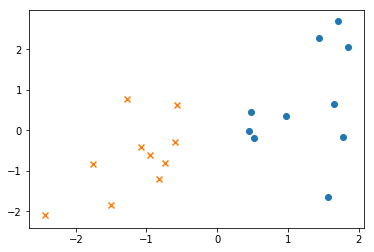

In [24]:
ut.plot2DSet(the_set)

In [25]:
entropie(Lsup)

0

### Représentation d'un arbre en Python

Un arbre de décision doit être représenté en Python, pour cela, on utilise la classe <code>ArbreBinaire</code> suivante:

In [26]:
import graphviz as gv
# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz


class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

True


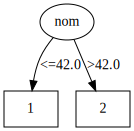

In [27]:
# Exemple d'utilisation: 
un_arbre= ArbreBinaire()
un_arbre.ajoute_feuille(1)
print(un_arbre.est_feuille())
un_arbre1 = ArbreBinaire()
un_arbre1.ajoute_feuille(2)
un_arbre2 = ArbreBinaire()
un_arbre2.ajoute_fils(un_arbre,un_arbre1,"nom",42.0)

gtree = gv.Digraph(format='png')
un_arbre2.to_graph(gtree)

### Construction de l'arbre de décision

Pour construire un arbre de décision, il faut réaliser les étapes suivantes:
- si l'entropie de Shannon de la distribution des classes de l'ensemble courant est inférieure(ou egale) à epsilon (réel positif fixé et qui est un paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire;
- sinon, pour chaque attribut, calculer le seuil de discrétisation et l'entropie de Shannon correspondante
    - choisir l'attribut qui donne une valeur d'entropie minimale
    - l'attribut choisi sert à constituer un noeud de l'arbre de décision, les arcs issus de ce noeud sont labeller par un test (inférieur ou égal ou supérieur) par rapport au seuil trouvé
    
    
<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction qui construit un arbre de décision (binaire) à partir d'une base d'exemples. En plus de la base d'exemples, on utilise un argument "epsilon" qui est un réel >0 et qui sert pour le critère d'arrêt.
Cette fonction a la spécification suivante:

    def construit_AD(LSet,epsilon):
        """ LSet : LabeledSet
            epsilon : seuil d'entropie pour le critère d'arrêt 
        """


In [28]:
def construit_AD(LSet, epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    if entropie(LSet) <= epsilon:
        feuille = ArbreBinaire()
        feuille.ajoute_feuille(classe_majoritaire(LSet))
        return feuille
    taille = LSet.getInputDimension()
    entro = 1.1     
    seuil = None
    att = None
    for col in range(taille): 
        se_test, ent_test = discretise(LSet, col)
        if entro > ent_test:
            att = col
            entro = ent_test
            seuil = se_test
    noeud = ArbreBinaire()
    LSGauche, LSDroite = divise(LSet, att, seuil)   
    ADGauche = construit_AD(LSGauche, epsilon)
    ADDroite = construit_AD(LSDroite, epsilon)
    noeud.ajoute_fils(ADGauche, ADDroite, att, seuil)
    return noeud
    

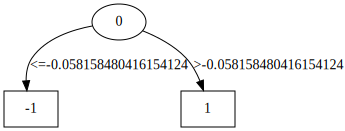

In [29]:
#test de l'affichage 
abin = construit_AD(the_set,0.0)
gtree = gv.Digraph(format='png')
abin.to_graph(gtree)

### Classification avec arbre de décision


Pour classer un nouvel exemple avec un arbre de décision, il faut parcourir l'arbre, de la racine vers une feuille en respectant les tests rencontrés dans chaque arc. Une fois atteint une feuille, la classe de l'exemple est celle présente dans la feuille.

La classe ArbreBinaire contient déjà une fonction <code>classifie</code> qui permet de classer un nouvel exemple et de renvoyer la classe +1 ou -1 selon le cas.

### Implémentation

On définit le classifieur <code>ArbreDecision</code> comme suit.

Si toutes les fonctions précédentes ont été écrites correctement, il est maintenant possible de construire un arbre de décision à partir de la base jouet.


## Applications à des données réelles

In [30]:
class ArbreDecision(cl.Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_AD(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

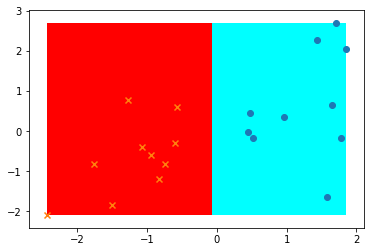

In [31]:
# un exemple d'utilisation:
ad=ArbreDecision(0.0)          # initialiation d'un arbre binaire qui utilisera epsilon= 0.0
ad.train(the_set)              # construction de l'arbre à partir de la base jouet
ut.plot_frontiere(the_set,ad,20)  # tracé graphique de la frontière de décision
ut.plot2DSet(the_set) 

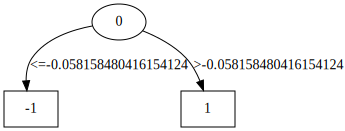

In [32]:
ad.plot()

<font color="RED" size="+1">**[Q]**</font> Appliquer l'algorithme des arbres de décision à des données réelles (par exemple, celles utilisées avec les k-nn) et comparer les résultats obtenus par les 2 algorithmes.

Un autre exemple d'utilisation sur une base plus grande:

Taille de la base générée : 200 exemples


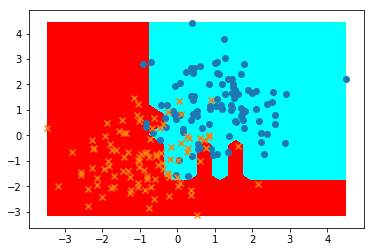

In [33]:
autre_set=ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
print("Taille de la base générée :", autre_set.size(), "exemples")
adautre=ArbreDecision(0.0)          
adautre.train(autre_set)            
ut.plot_frontiere(autre_set,adautre,20)
ut.plot2DSet(autre_set) 

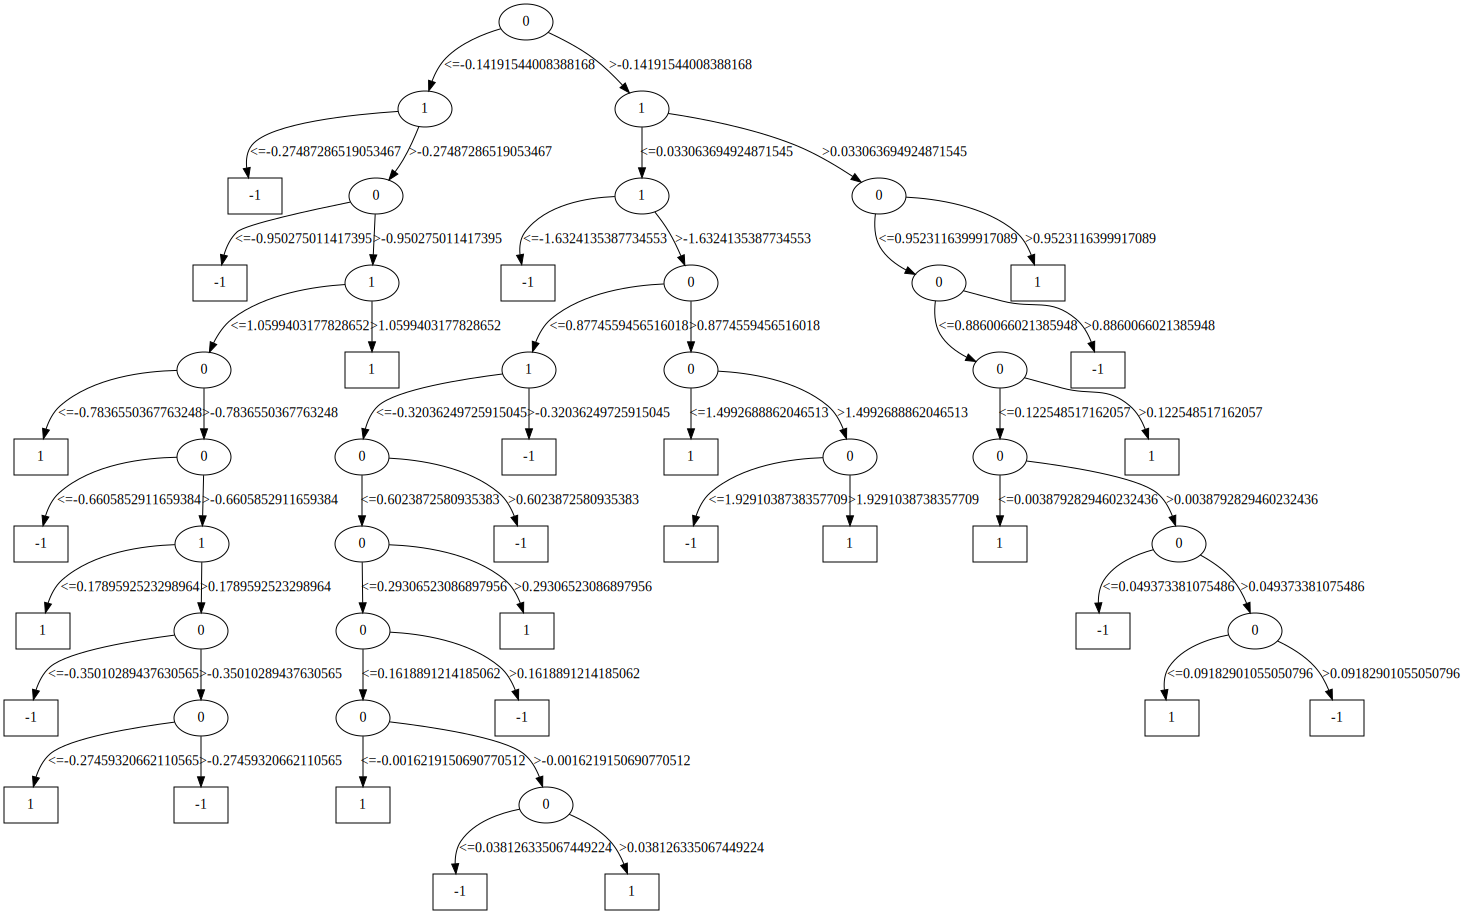

In [34]:
adautre.plot()

### Améliorations (facultatif)

Adapter votre algorithme afin de pouvoir construire des arbres de décision avec des attributs catégoriels. Dans un premier temps, vous considèrerez des attributs catégoriels à 2 valeurs. Ensuite, pour considérer des attributs à plus de 2 valeurs, vous devrez écrire une classe <code>ArbreGeneral</code> pour remplacer la classe <code>ArbreBinaire</code>.

## Etape 3: Expérimentation

Comparez le résultat obtenu avec ceux obtenus avec les 2 classifiers implémentés lors des TD-TME précédents. Ensuite, utilisez votre implémentation sur d'autres bases de données que vous avez déjà trouvées ou que vous pourrez trouver sur le web.